<a href="https://colab.research.google.com/github/zClarkk/Medical-Deep-Learning-Collection/blob/main/Model_Distillation_and_Ternary_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Deep Learning
## Exercise 5: Model Distillation & Ternary Nets

The goal of this exercise is to implement methods that allow to compress deep learning models via model distillation and ternary weights. This enables the use of deep learning in medicine due to its real-time ability and implementation on weaker mobile devices.

In [ ]:
!pip install torchinfo

In [ ]:
#run pip install for pytorch flop counter before first use
!pip install onnx wget
!pip install --upgrade git+https://github.com/Lyken17/pytorch-OpCounter.git

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil,gzip
import wget

#some functions to count unique parameters and sparsity are provided
def countParameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([p.numel() for p in model_parameters])
    return params

def countUnique(net):
    unique = 0
    for m in net.modules():
        if(isinstance(m,nn.Conv2d)):
            unique += len(np.unique(m.weight.data.cpu().flatten().numpy()))
    return unique
    #print('#unique',unique)

def countSparsity(net):
    count_nonzero = 0; count_zero = 0
    for m in net.modules():
        if(isinstance(m, nn.Conv2d)):
            count_nonzero += torch.sum((m.weight.data!=0).float())
            count_zero += torch.sum((m.weight.data==0).float())
    return count_zero/(count_zero+count_nonzero)


## Dataset
We will use the data of the Patch Camelyon (tupac16) Challenge. It consists of $327\,680$ color images extracted from histopathologic scans of lymph node sections. The task is to classify the presence of metastatic tissue (global binary labels are given). The images were preprocessed to a spatial dimension of $48\times48$ and split to 65k for training and 16k for testing images. See [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) for further details.

In [ ]:
#loading the patch-based wholeslide histopathology data (uint8) and converting it to torch tensors
import os

dataset_url = #REDACTED

def get_data(data_url):
    filename = './patchCamelyon8c.mat'
    if not os.path.exists(filename):
        filename = wget.download(data_url)

get_data(dataset_url)


data = scipy.io.loadmat('patchCamelyon8c.mat')

img_train = torch.from_numpy(data['img_train'].astype('float32')/255)
img_test = torch.from_numpy(data['img_test'].astype('float32')/255)

label_train = torch.from_numpy(data['label_train']).long()
label_test = torch.from_numpy(data['label_test']).long()

Let's visualize an example for the two classes. You can run the cell multiple times, getting each time new random examples.

index for no metastatic tissue: 38939
index for metastatic tissue: 34097


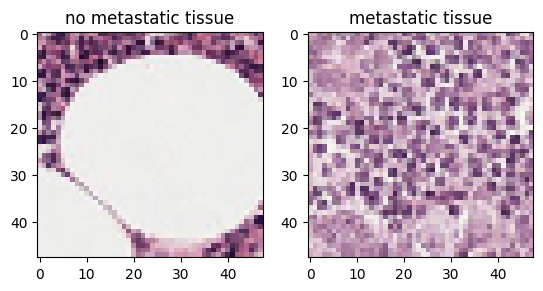

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2)
idx_negative = torch.where(label_train.squeeze() == 0)[0]
idx_negative = idx_negative[torch.randperm(len(idx_negative))[0]]

idx_positive = torch.where(label_train.squeeze() == 1)[0]
idx_positive = idx_positive[torch.randperm(len(idx_positive))[0]]

print('index for no metastatic tissue:', idx_negative.item())
print('index for metastatic tissue:', idx_positive.item())

ax1.imshow(img_train[idx_negative].permute(1, 2, 0))
ax1.set_title('no metastatic tissue')
ax2.imshow(img_train[idx_positive].permute(1, 2, 0))
ax2.set_title('metastatic tissue')
plt.show()

We load a pretrained `VGG11`, inspect its architecture and gather some computational information.

In [ ]:
from torchinfo import summary
net = torchvision.models.vgg11_bn(pretrained='True')

summary(net, (128, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [128, 1000]               --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 48, 48]         128
│    └─ReLU: 2-3                         [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-4                    [128, 64, 24, 24]         --
│    └─Conv2d: 2-5                       [128, 128, 24, 24]        73,856
│    └─BatchNorm2d: 2-6                  [128, 128, 24, 24]        256
│    └─ReLU: 2-7                         [128, 128, 24, 24]        --
│    └─MaxPool2d: 2-8                    [128, 128, 12, 12]        --
│    └─Conv2d: 2-9                       [128, 256, 12, 12]        295,168
│    └─BatchNorm2d: 2-10                 [128, 256, 12, 12]        512
│    └─ReLU: 2-11                        [128, 256, 12, 12]        --


## Task 0 (15 points): Modify a pretrained VGG11_BN network for the given training data
Complete the function below, which returns a VGG11-Net with its architecture modified accordingly to match the tupac16 dataset.
+ Replace the layer `net.avgpool` with an adaptive average pool of output size $1\times1$
+ Create a new classifier as `nn.Sequential` with two linear layers ($512\times256$ and $256\times2$) including one ReLU and no batch-norm.

In [ ]:
def tupac16_vgg11():
    net = torchvision.models.vgg11_bn(pretrained='True')
    net.avgpool = nn.AdaptiveAvgPool2d(1)
    net.classifier = nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Linear(256,2))

    return net

Check the reduced parameter count using `summary` from `torchinfo`. Your should obtain about $9\,357\,826$ parameters.

In [ ]:
net = tupac16_vgg11()
summary(net, (128, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [128, 2]                  --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 48, 48]         128
│    └─ReLU: 2-3                         [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-4                    [128, 64, 24, 24]         --
│    └─Conv2d: 2-5                       [128, 128, 24, 24]        73,856
│    └─BatchNorm2d: 2-6                  [128, 128, 24, 24]        256
│    └─ReLU: 2-7                         [128, 128, 24, 24]        --
│    └─MaxPool2d: 2-8                    [128, 128, 12, 12]        --
│    └─Conv2d: 2-9                       [128, 256, 12, 12]        295,168
│    └─BatchNorm2d: 2-10                 [128, 256, 12, 12]        512
│    └─ReLU: 2-11                        [128, 256, 12, 12]        --


## Task1 (25 points): Fine tuning
Fine-tune this network for 16 sub-epochs on the tupac16 dataset. One sub-epoch is defined as a random quarter of the training pathes. Use `torch.randperm` to generate the needed indices for every epoch. The batch size should be 128. Choose Adam as an optimizer with an initial learning rate of 0.0005 and an exponential learning rate scheduler with `gamma=0.9`. After training, evaluate the model on the test data. It should yield an accuracy about $94\%$.

**Note:** Task 2 and 3 can be performed independently, but you should store each trained network under a new filename (for comparisons). In the following all techniques should only be applied to the feature-part of the network (and not the classifier layers).

**Hint**: If you struggle with implementing of the training routine, have a look at the previous exercises.

In [ ]:
len(img_train)

65536

In [ ]:
def my_loss(net):
  tl = 0
  for x in net.modules():
    if isinstance(x,nn.BatchNorm2d):
      tl +=sum(abs(x.bias))
      tl +=sum(abs(x.weight))

  return tl

In [ ]:

def train(net,custom_loss=False):
  net.cuda()

  num_epochs = 16

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(), 0.0005)

  # learning rate scheduler
  lr_scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9)

  # criterion

  criterion = nn.CrossEntropyLoss().cuda()
  if custom_loss:
    pass

  # statistics
  train_loss = torch.zeros(num_epochs, device='cuda')
  train_acc = torch.zeros_like(train_loss)


  # for num_epochs
  for epoch in range(num_epochs):

      # train mode
      net.train()

      rand = torch.randperm(len(img_train))
      for i in range(0,len(img_train)//4,128):
          input = img_train[rand[i:i+128]].cuda()
          target = label_train[0][rand[i:i+128]].cuda()
          output = net(input)
          loss = criterion(output,target)
          if custom_loss:
            loss+=0.04*my_loss(net)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # statistics
          train_loss[epoch] += loss.detach()
          train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

      # update learning rate
      lr_scheduler.step()
      # todo

      train_loss[epoch] /= len(img_train)//4/128
      train_acc[epoch] /=  len(img_train)//4/128

      # output
      print('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))
  return net
# todo

In [ ]:
def evaluate(net):
  net.eval()
  acc = 0
  for i in range(0,len(img_test),32):
    input = img_test[i:i+128].cuda()
    target = label_test[0][i:i+128].cuda()
    output = net(input)
    acc += torch.mean((torch.argmax(output, dim=-1) == target).float())
  print(f"Test accuracy: {acc/(len(img_test)//32)}")

In [ ]:
net = tupac16_vgg11()
net = train(net)
evaluate(net)

Epoch 0 (train) -- loss: 0.3454 accuracy: 0.8488
Epoch 1 (train) -- loss: 0.2548 accuracy: 0.8977
Epoch 2 (train) -- loss: 0.2070 accuracy: 0.9206
Epoch 3 (train) -- loss: 0.1826 accuracy: 0.9301
Epoch 4 (train) -- loss: 0.1606 accuracy: 0.9387
Epoch 5 (train) -- loss: 0.1389 accuracy: 0.9505
Epoch 6 (train) -- loss: 0.1099 accuracy: 0.9596
Epoch 7 (train) -- loss: 0.1026 accuracy: 0.9626
Epoch 8 (train) -- loss: 0.0781 accuracy: 0.9731
Epoch 9 (train) -- loss: 0.0762 accuracy: 0.9731
Epoch 10 (train) -- loss: 0.0647 accuracy: 0.9781
Epoch 11 (train) -- loss: 0.0492 accuracy: 0.9832
Epoch 12 (train) -- loss: 0.0422 accuracy: 0.9855
Epoch 13 (train) -- loss: 0.0375 accuracy: 0.9881
Epoch 14 (train) -- loss: 0.0319 accuracy: 0.9899
Epoch 15 (train) -- loss: 0.0258 accuracy: 0.9915
Test accuracy: 0.9414825439453125


## Task 2 (60 points): Network Pruning through increased Sparsity
+ Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before by calling your `tupac16_vgg11` method.
+ Reuse the training routine from above.
+ Add a sparsity promoting L1-loss (sum of absolute values) with a weight factor of 0.04 to the classification loss on the weights and bias of each BatchNorm2d.
    + Therefor iterate over all modules of the net using `modules()` and determine the layer type using `isinstance()`
+ Retrain the network.
+ Evaluate its test accuracy (will drop slightly to ~89%).

In [ ]:
# Task 2
net = tupac16_vgg11()
net = train(net,True)
evaluate(net)
# todo

Epoch 0 (train) -- loss: 74.5117 accuracy: 0.8522
Epoch 1 (train) -- loss: 61.6916 accuracy: 0.8974
Epoch 2 (train) -- loss: 50.7317 accuracy: 0.9127
Epoch 3 (train) -- loss: 41.5752 accuracy: 0.9166
Epoch 4 (train) -- loss: 34.1936 accuracy: 0.9170
Epoch 5 (train) -- loss: 28.6857 accuracy: 0.9136
Epoch 6 (train) -- loss: 24.8101 accuracy: 0.9158
Epoch 7 (train) -- loss: 22.0793 accuracy: 0.9127
Epoch 8 (train) -- loss: 20.0344 accuracy: 0.9172
Epoch 9 (train) -- loss: 18.4257 accuracy: 0.9203
Epoch 10 (train) -- loss: 17.0958 accuracy: 0.9233
Epoch 11 (train) -- loss: 15.9833 accuracy: 0.9247
Epoch 12 (train) -- loss: 15.0110 accuracy: 0.9285
Epoch 13 (train) -- loss: 14.1847 accuracy: 0.9294
Epoch 14 (train) -- loss: 13.4591 accuracy: 0.9285
Epoch 15 (train) -- loss: 12.8136 accuracy: 0.9360
Test accuracy: 0.9016672968864441


In [ ]:
torch.save(net,'tupac_sparse_net.pth')

Write a function that determines a threshold for input/output neurons to be set to zero (the ones which have been reduced in absolute value using the sparsity constraint). You can use the function `topk`, which outputs both the values and indices sorted around a chosen quantile/percentile. Here we simply use the median to set 50% of values to zero.

When applied correctly (as incoming & outgoing mask) for each Conv2d layer, it reduces the nonzero parameters by ~75% (the first incoming & last outgoing Conv2d are not masked).
Note that BatchNorm has four tensors and two index masks have to be applied as follows:

`B = A[idx_next,:,:,:][:,idx_prev,:,:]`

Now you can replace all Conv2d and BatchNorm2d layers with smaller filters (and copy their weights) so that we have the following sequence of channels: 3, 32, 64, (2x)128, (3x)256, 512.
Evaluate the slimmed network (you could observe a slight improvement to ~92%) and confirm that the required computations are reduced to 12 GFlops.

In [ ]:
# task 2 Network slimming (construct lean filters)

sparsity_s = 0.04
ternary = False

model_name = 'tupac_sparse'

net = torch.load(model_name+'_net.pth')

net.eval()
net.cuda()
last_layer_size = 3
last_mask = torch.ones(3).cuda()
idx_prev = torch.arange(3).long().cuda()
q75 = 0.5
print('#params before',countParameters(net.features))
print('#features sparsity',countSparsity(net.features))


for c in range(len(net.features)-2):
    if isinstance(net.features[c], nn.Conv2d):

        if(c==25):
            q75=1
        new_layer_size = int(q75*len(net.features[c].weight))
        print("before",net.features[c].weight.shape)
        tk =  torch.topk((net.features[c+1].weight.data),int(q75*len(net.features[c+1].weight.data)))
        mask = net.features[c+1].weight.data >= tk[0][-1]

        new_layer = nn.Conv2d(last_layer_size,new_layer_size,3,1,1,bias=False).cuda()

        with torch.no_grad():
          xd = net.features[c].weight[mask]
          new_layer.weight[:,:,:,:] = xd[:,idx_prev,:,:]
          #new_layer.bias[:] = net.features[c].bias[mask]


        new_batchNorm = nn.BatchNorm2d(new_layer_size).cuda()
        with torch.no_grad():

          new_batchNorm.weight.data[:] = net.features[c+1].weight.data[mask]
          new_batchNorm.bias.data[:] = net.features[c+1].bias.data[mask]
          new_batchNorm.running_mean.data[:] = net.features[c+1].running_mean.data[mask]
          new_batchNorm.running_var.data[:] = net.features[c+1].running_var.data[mask]

        with torch.no_grad():
          net.features[c] = new_layer

        with torch.no_grad():
          net.features[c+1] =  new_batchNorm

        last_layer_size = new_layer_size
        print("after",net.features[c].weight.shape)
        idx_prev = mask
        q7 = 0.5

# evaluation for task 2

print('#params after',countParameters(net.features))
print('#features sparsity',countSparsity(net.features))

idx_epoch = torch.arange(16384).view(128,-1)
val_acc = 0

for iter in range(idx_epoch.size(1)):
    idx_iter = idx_epoch[:,iter]

    with torch.no_grad():
        #forward path and loss
        outputs = net(img_test[idx_iter,:,:,:].cuda())
    val_acc += torch.sum((outputs.argmax(1).cpu()==label_test[0,idx_iter]).float())/16384.0

print(f"Accuracy: {val_acc.item():.7f}")

#params before 9225984
#features sparsity tensor(0., device='cuda:0')
before torch.Size([64, 3, 3, 3])
after torch.Size([32, 3, 3, 3])
before torch.Size([128, 64, 3, 3])
after torch.Size([64, 32, 3, 3])
before torch.Size([256, 128, 3, 3])
after torch.Size([128, 64, 3, 3])
before torch.Size([256, 256, 3, 3])
after torch.Size([128, 128, 3, 3])
before torch.Size([512, 256, 3, 3])
after torch.Size([256, 128, 3, 3])
before torch.Size([512, 512, 3, 3])
after torch.Size([256, 256, 3, 3])
before torch.Size([512, 512, 3, 3])
after torch.Size([256, 256, 3, 3])
before torch.Size([512, 512, 3, 3])
after torch.Size([512, 256, 3, 3])
#params after 2897952
#features sparsity tensor(0., device='cuda:0')
Accuracy: 0.9076538


In [ ]:
summary(net)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       864
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       18,432
│    └─BatchNorm2d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       73,728
│    └─BatchNorm2d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─Conv2d: 2-12                      147,456
│    └─BatchNorm2d: 2-13                 256
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      294,912
│    └─BatchNorm2d: 2-17                 512
│    └─ReLU: 2-18                        --
│    └─Conv2d: 2-19                      589,824

## Bonus Task - Ternary Nets:
Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before. Finally, we want to explore, how the memory storage can be reduced with little loss. Here a ternary weight approximation will be used for which we first estimate a per-channel $\Delta$ for each weight in Conv2d given the rule-of-thumb below.

$\begin{align}
    \Delta &= \frac{0.7}{n}\sum^n_{i=1}|W_i|\\
    \tilde{W}_i&=
    \begin{cases}
        +1, &\text{ if } W_i > \Delta\\
        0,  &\text{ if } |W_i| \leq \Delta\\
        -1,  &\text{ else }
    \end{cases}\\
    n_\Delta &= \sum_i|\tilde{W}_i|\\
    \alpha &= \frac{1}{n_\Delta}\sum_i|\tilde{W}_i||W_i|
\end{align}$

Tip: after calculating the absolute values the mean has to be computed over all but the 0-th dimension.
The obtained ternary weights have lost their magnitude, therefore the parameter $\alpha$ (again per-channel) is computed and multiplied with the weight tensor.

Test your function with the check implemented below. For a $128\times64\times3\times3$ kernel the number of unique entries is reduced from more than 70 thousand to just 257 ($2 \cdot 128 + 1$).

In [ ]:
net = tupac16_vgg11()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# template for function in bonus task
def approx_weights(w_in,flag=True):
    if(flag):
        with torch.no_grad():

          a, b, c, d = w_in.size()
          delta = 0.7 * torch.mean(w_in, dim=(1, 2, 3))
          w_wave = torch.ones_like(w_in) * -1
          w_wave[w_in > delta[:, None, None, None]] = 1
          w_wave[torch.abs(w_in) <= delta[:, None, None, None]] = 0
          n_delta = torch.sum(torch.abs(w_wave), dim=(1, 2, 3))
          alpha = torch.sum(torch.abs(w_wave) * torch.abs(w_in), dim=(1, 2, 3)) / n_delta
          w_out = w_wave * alpha[:, None, None, None]



    else:
        w_out = w_in
    return w_out

# check the number of unique values before/after ternary approximation
w_in = net.features[4].weight.clone().detach()
w_approx = approx_weights(w_in,True)
print('#unique',len(np.unique(w_in.data.cpu().flatten().numpy())))
print('#unique',len(np.unique(w_approx.data.cpu().flatten().numpy())))

#unique 73673
#unique 257


To effectively train a network with weight quantisation, it is important to only use the ternary weights during forward/backward path, but update their gradients in full precision.

Implement a loop that stores full precision weights in a list of tensors and replaces the `.data` values with their approximation just before calling the forward pass (and zero_grad).
Reassign these backup copies after `loss.backward()` and `before optimizer.step()`. Retrain your network and take care to perform the weight quantisation the same way during test evaluation. The test accuracy should be around 85-90% during the epochs.

**Tip:** you could use `.pop(0)` to (iteratively) access and remove the first object of a list.

In [ ]:
# todo

In [ ]:
def replace_and_store(net):
  copies = []
  for c in range(len(net.features)-2):
      if isinstance(net.features[c], nn.Conv2d):
          w_in = net.features[c].weight.data
          w_out = approx_weights(w_in,flag=True)
          copies.append(w_in)
          with torch.no_grad():
              net.features[c].weight.data[:] = w_out
  return net, copies

In [ ]:
def recover(net,copies):
    for c in range(len(net.features)-1,-1,-1):
        if isinstance(net.features[c], nn.Conv2d):
          w_old = copies.pop()
          with torch.no_grad():
            net.features[c].weight.data[:] = w_old
    return net

In [ ]:
def train_ternary(net):
  net.cuda()

  num_epochs = 16

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(), 0.0005)

  # learning rate scheduler
  lr_scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9)

  # criterion

  criterion = nn.CrossEntropyLoss().cuda()


  # statistics
  train_loss = torch.zeros(num_epochs, device='cuda')
  train_acc = torch.zeros_like(train_loss)


  # for num_epochs
  for epoch in range(num_epochs):

      # train mode
      net.train()

      rand = torch.randperm(len(img_train))
      for i in range(0,len(img_train)//4,128):
          input = img_train[rand[i:i+128]].cuda()
          target = label_train[0][rand[i:i+128]].cuda()
          net, cops = replace_and_store(net)
          output = net(input)
          loss = criterion(output,target)
          optimizer.zero_grad()
          loss.backward()
          net = recover(net,cops)
          optimizer.step()
          # statistics
          train_loss[epoch] += loss.detach()
          train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

      # update learning rate
      lr_scheduler.step()

      train_loss[epoch] /= len(img_train)//4/128
      train_acc[epoch] /=  len(img_train)//4/128

      # output
      print('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))
  return net

In [ ]:
def evaluate_ternary(net):
  net.eval()
  acc = 0
  net, cops = replace_and_store(net)
  for i in range(0,len(img_test),32):
    input = img_test[i:i+128].cuda()
    target = label_test[0][i:i+128].cuda()
    output = net(input)
    acc += torch.mean((torch.argmax(output, dim=-1) == target).float())
  print(f"Test accuracy: {acc/(len(img_test)//32)}")

In [ ]:
net = tupac16_vgg11()
net = train_ternary(net)
evaluate_ternary(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 (train) -- loss: 0.5592 accuracy: 0.7042
Epoch 1 (train) -- loss: 0.4307 accuracy: 0.8063
Epoch 2 (train) -- loss: 0.4110 accuracy: 0.8151
Epoch 3 (train) -- loss: 0.3917 accuracy: 0.8221
Epoch 4 (train) -- loss: 0.3892 accuracy: 0.8225
Epoch 5 (train) -- loss: 0.3877 accuracy: 0.8248
Epoch 6 (train) -- loss: 0.3826 accuracy: 0.8269
Epoch 7 (train) -- loss: 0.3735 accuracy: 0.8318
Epoch 8 (train) -- loss: 0.3751 accuracy: 0.8327
Epoch 9 (train) -- loss: 0.3692 accuracy: 0.8360
Epoch 10 (train) -- loss: 0.3630 accuracy: 0.8378
Epoch 11 (train) -- loss: 0.3654 accuracy: 0.8353
Epoch 12 (train) -- loss: 0.3624 accuracy: 0.8373
Epoch 13 (train) -- loss: 0.3602 accuracy: 0.8395
Epoch 14 (train) -- loss: 0.3515 accuracy: 0.8438
Epoch 15 (train) -- loss: 0.3553 accuracy: 0.8413
Test accuracy: 0.830230712890625
